# Computer Vision with CNNs - INF573 week5

*Convolutional neural networks* are an important class of learnable representation applicable, amongst others, to numerous computer vision problems. Deep CNNs, in particular, are composed of several layers of processing, each involving linear as well as non-linear operators, that are learned jointly, in an end-to-end manner, to solve a particular task. These methods are now the dominant approach for feature extraction from audiovisual and textual data.

This practical explores the basics of learning (deep) CNNs. The first part introduces typical CNN building blocks, such as ReLU units and linear filters. The second part looks at learning two basic CNNs. The first one is a simple non-linear filter capturing particular image structures, while the second one is a network that recognises typewritten characters (using a variety of different fonts). These examples illustrate the use of stochastic gradient descent with momentum, the definition of an objective function, the construction of mini-batches of data, and data jittering. The last part shows how powerful CNN models can be downloaded off-the-shelf and used directly in applications, bypassing the expensive training process.

There are in total several tasks that you can complete, eight questions and some bonus. 

**Homework**: You are asked to send over *only* the eight (8) questions, not the tasks. 
**Bonus**: questions marked as bonus.

**Submission Instructions:**
For your answers: Please submit a single zip file as follows: 

"INF573-Lab5-\<Surname\>-\<Name\>.zip", eg if your name is (first name, last name) "Yann LeCun", write: INF573-Lab5-LeCun-Yann.zip

Inside the zip file, please include two files: 

(a) Printscreen image with your image for question 8 with the name: "MyImage.png"

(b) A single text file called "MyAnswer.txt" with your answer in the following form: 

Question 1: xxxx
    
Question 2: xxx

Question 3: xxx

Question 4: 

...

Question 8: My image shows a hat
 

If you do not know the answer to one question, leave it blank, please (write down the question)

$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\bp}{\mathbf{p}}
\newcommand{\cP}{\mathcal{P}}
\newcommand{\cN}{\mathcal{N}}
\newcommand{\vv}{\operatorname{vec}}
$$

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
import os

In [4]:
# IF USING COLAB, UNCOMMENT THE LINES BELOW 
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [5]:
# IF USING COLAB, UNCOMMENT THE LINES BELOW 
#path_to_my_drive = '/content/gdrive/mypythondirectory' # CHANGE 
#sys.path.append(path_to_my_drive)

<a id='part1.1'></a>
## Part 1: CNN building blocks

### Part 1.1: convolution

A feed-forward neural network can be thought of as the composition of number of functions 
$$
f(\bx) = f_L(\dots f_2(f_1(\bx;\bw_1);\bw_2)\dots),\bw_{L}).
$$
Each function $f_l$ takes as input a datum $\bx_l$ and a parameter vector $\bw_l$ and produces as output a datum $\bx_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\bw=(\bw_1,\dots,\bw_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\bx_1,\dots,\bx_n$ are images, sounds, or more in general maps from a lattice(πλεγμα
) to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\bx_i$ will be a $N\times C \times U_1 \times U_2$ real array of $U_1 \times U_2$ pixels and $C$ channels per pixel representing $N$ data samples. Hence the first dimension of the array spans data samples, the second spans feature channels and the last two span space width and height, respectively. Note that only the input $\bx=\bx_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

We will use the shorthand notation $U=U_1 \times U_2$ to lump together spatial dimensions, which also allows us to neatly generalize formulas to an arbitrary number of spatial dimensions (for example, in medical imaging one may have three to represent volumetric data).

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\bx_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\bx_l$.

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{N\times C\times U} \rightarrow \mathbb{R}^{N\times K \times V},
 \qquad \bx \mapsto \by.
$$
Let us try this out now.

The image tensor type is torch.float32
The image tensor shape is [1, 3, 384, 512]


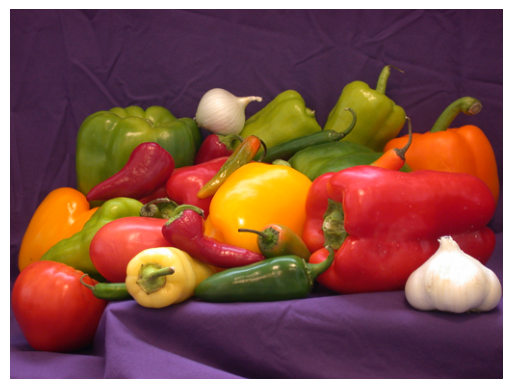

In [6]:
import lab
from PIL import Image # To read images as numpy arrays 
from matplotlib import pyplot as plt
import numpy as np

x = lab.imread('data/peppers.png')  # Read an image as a PyTorch tensor
  
# plt.figure(1, figsize=(12,12))  # Visualize the input x
lab.imarraysc(x)                  # Display the image

print(f"The image tensor type is {x.dtype}")        # Show the data type of the tensor
print(f"The image tensor shape is {list(x.shape)}") #  Show the shape of the tensor
#print(x2.dtype)

In [7]:
print("The shape of tensor is:", x.shape)
print("The data type of the tensor is:", x.dtype)

The shape of tensor is: torch.Size([1, 3, 384, 512])
The data type of the tensor is: torch.float32


Use `x.shape` to obtain the shape of the tensor `x` and `x.dtype` to obtain its data type. Note that the tensor `x` is converted to *single precision* format. This is because the underlying PyTorch assumes that data is in single precision in most cases.

> **Question 1:** The first dimension of `x` is 3. Why?

Next, we create a bank of 10 filters, each of dimension $3\times 5 \times 5$, initialising their coefficients randomly:

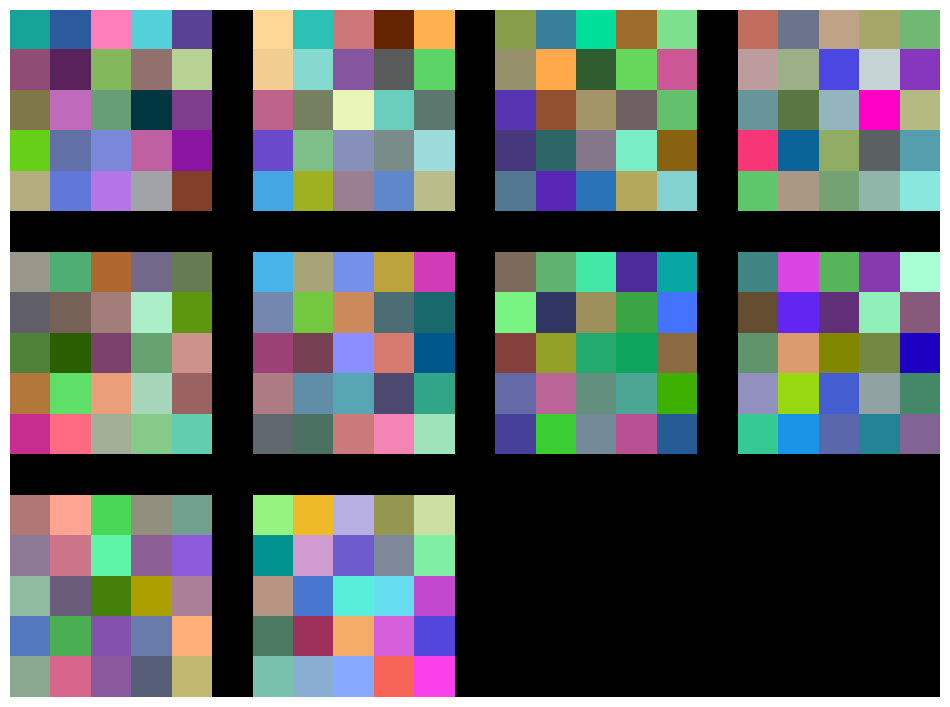

In [8]:
import torch

# Create a bank of linear filters
w = torch.randn(10,3,5,5) # 10 filters, 3 input channels, 5x5 kernel 

# Visualize the filters
plt.figure(1, figsize=(12,12))
lab.imarraysc(w, spacing=1) ;

The filters are in single precision as well. Note that `w` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image. This uses the `conv2d` function from `torch.nn.functional`:

In [9]:
import torch.nn.functional as F

print(x.shape, w.shape)
y = F.conv2d(x, w)                      # Apply the convolution operator
print(f"The output shape is {y.shape}") # Visualize the convolution result

torch.Size([1, 3, 384, 512]) torch.Size([10, 3, 5, 5])
The output shape is torch.Size([1, 10, 380, 508])


The variable `y` contains the output of the convolution. Note that the 10 filters are three-dimensional, packed in a four-dimensional tensor. This is because they operate on a tensor $\bx$ with $C$ channels. Furthermore, there are $K$ such filters, generating a $K$ dimensional map $\by$ as follows:

$$
y_{nkv} = \sum_{cu} w_{kcu} x_{n,c,u+v}
$$

> **Question 2:** Study carefully this expression and answer the following:
> 
> 
>  - Given that the input map $\bx$ has $C \times U_1\times U_2$ dimensions and that each of the $K$ filters has dimension $C\times F_1 \times F_2$, what is the dimension of $\by$?

> **Task:** check that the size of the variable `y` matches your calculations.

> Answer to the task:

    ([1, 10, 380, 508]) matches the calculations 




## Conv

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `conv2d`:

The downsampled output shape from the code that does not using padding is torch.Size([1, 10, 24, 32])


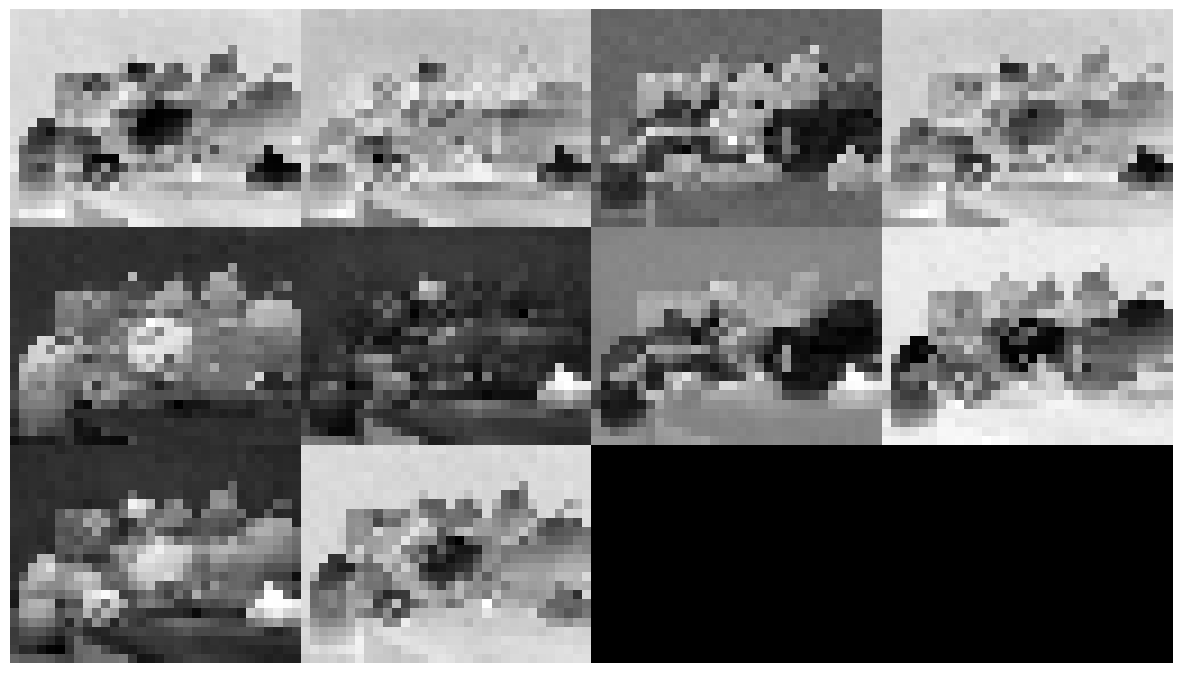

In [10]:
# Try again, downsampling the output
y_ds = F.conv2d(x, w, stride=16) 
print(f"The downsampled output shape from the code that does not using padding is {y_ds.shape}") 

plt.figure(figsize=(15, 10))
lab.imarraysc(lab.t2im(y_ds)) ; 

Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `padding` option:

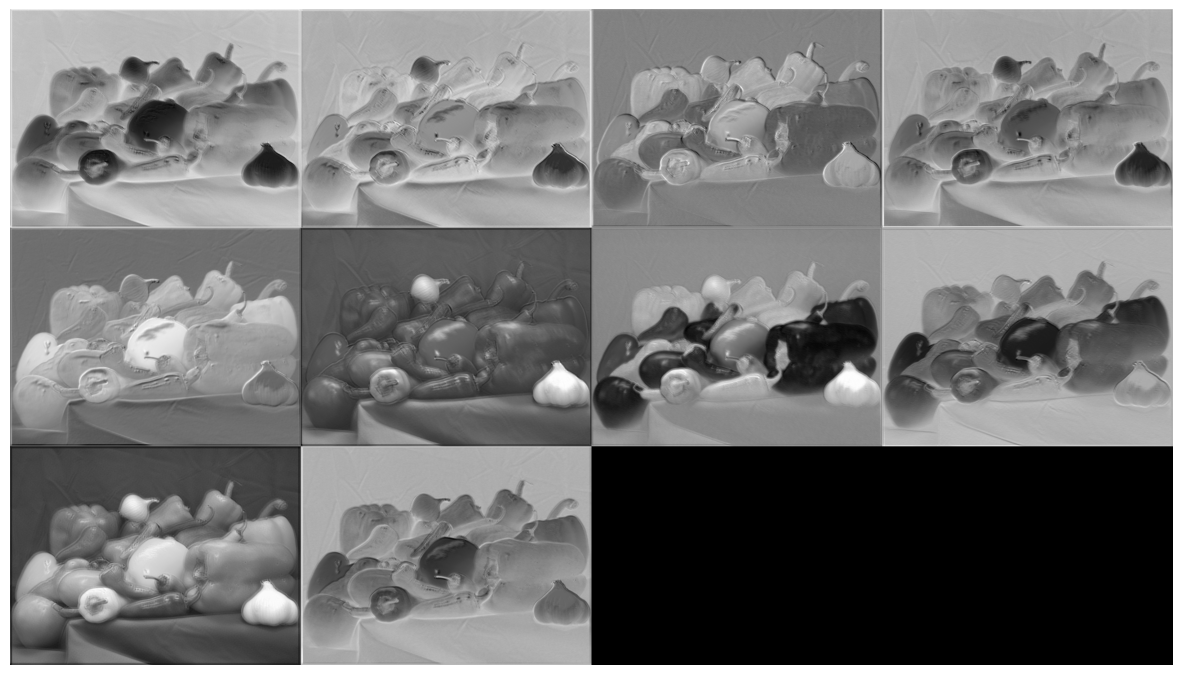

In [11]:
# Try again, downsampling the output
y_ds = F.conv2d(x, w, padding = 4)

plt.figure(figsize=(15, 10))
lab.imarraysc(lab.t2im(y_ds)) ;

In [12]:
print("the output shape from the previous code is:", y_ds.shape)

the output shape from the previous code is: torch.Size([1, 10, 388, 516])


> **Task:** Convince yourself that the previous code's output has different boundaries compared to the code that does not use padding. Can you explain the result?


> Answer to the task:

    To convince myself that the previous code's output has different boundaries compared to the code that does not use padding i will print the y_ds.shape in both outputs and i will compare the shapes.

    - The downsampled output shape from the code that does not using padding is torch.Size([1, 10, 24, 32])

    - The output shape from the previous code is: torch.Size([1, 10, 388, 516])

    So we can confirm that the previous code's output has different boundaries.

>> Explanation of the result:

    When we apply convolutional layers we tend to lose pixels on the perimeter of our image. This can been seen in the figure below, where the pixel utilization is depicted as a function of the convolution kernel size and the position within the image. The pixels in the corners are hardly used at all.

    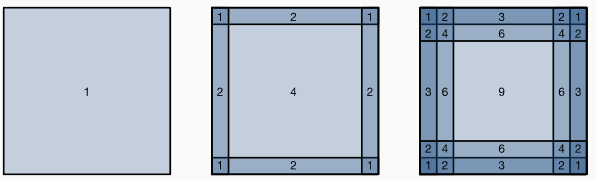

    *Pixel utilization for convolution of kernel size 1×1, 2×2 and 3×3 respectively*

    The solution to this problem is to add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image like in our case.


In order to consolidate what has been learned so far, we will now design a filter by hand:

The shape of the filter w is [1, 3, 3, 3]


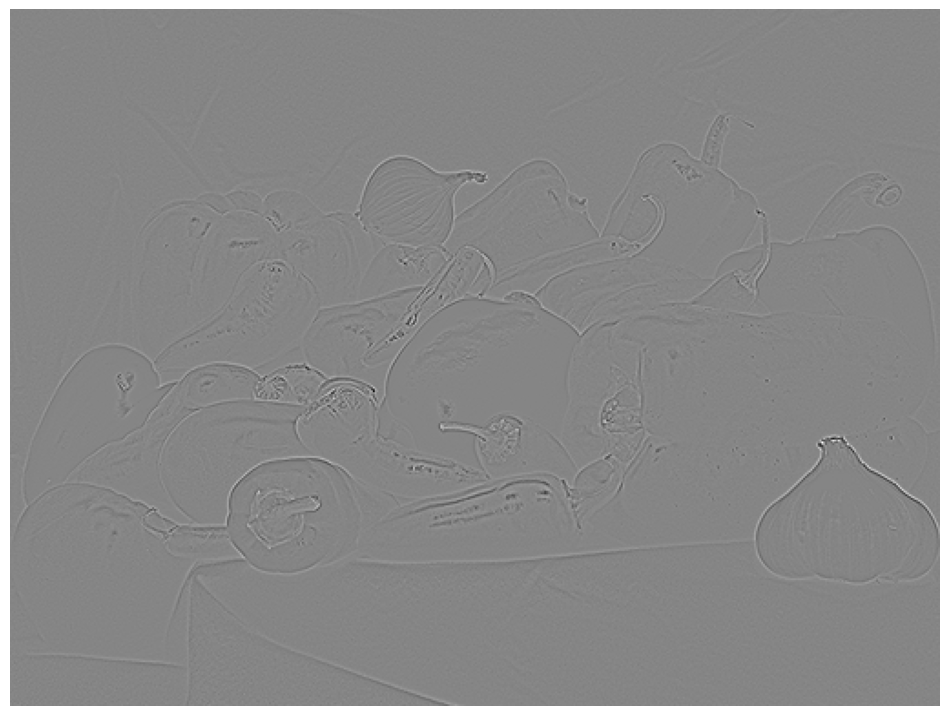

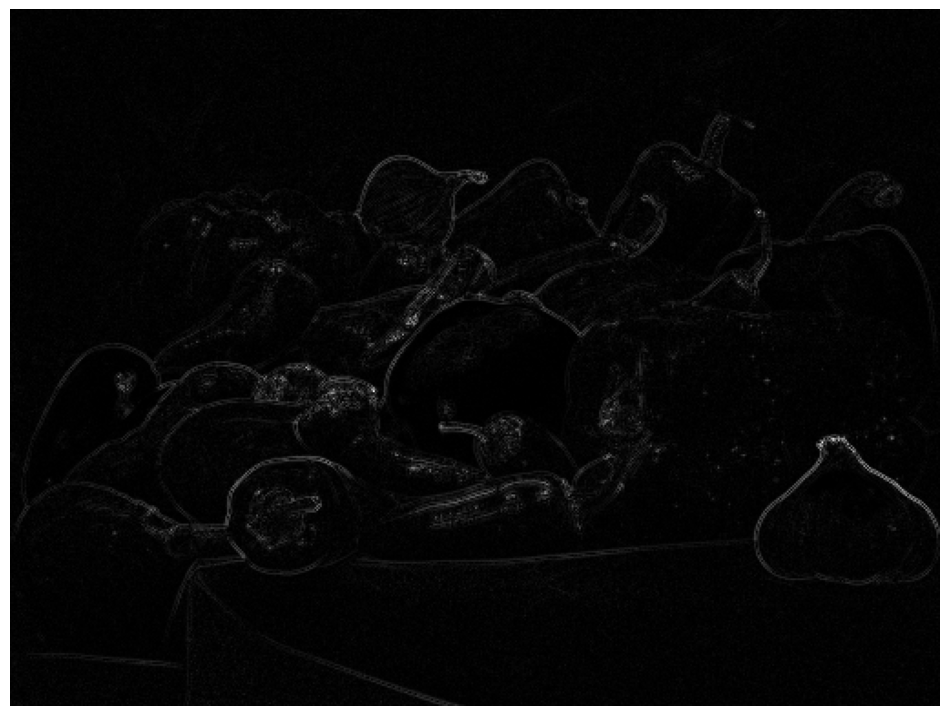

In [13]:
# Initialize a filter
w = torch.Tensor([
    [0,  1, 0 ],
    [1, -4, 1 ],
    [0,  1, 0 ]
])[None,None,:,:].expand(1,3,3,3)

print(f"The shape of the filter w is {list(w.shape)}")
#print(f"The filter is {w}")

# Apply convolution
y_lap = F.conv2d(x, w) ;

# Show the output
plt.figure(1,figsize=(12,12))
lab.imsc(y_lap[0])

# Show the output absolute value
plt.figure(2,figsize=(12,12))
lab.imsc(abs(y_lap)[0]) ;

> **Question 3:**
> 
> * (a) What filter have we implemented?
> * (b) What image structures are detected?
> * **bonus** How are the RGB colour channels processed by this filter?


### Part 1.2: non-linear activation functions

As we stated in the introduction, CNNs are obtained by composing several different functions. In addition to the linear filters shown in the [previous part](#part1.1), there are several non-linear operators as well.

> **Question 4:** Some of the functions in a CNN *must* be non-linear. Why?

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*

$$
  y_{cu} = \max\{0, x_{cu}\}.
$$

This function is implemented by `relu`; let's try this out:

The shape of the filter w is [1, 3, 3, 3]

 The filter is tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]],

         [[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])


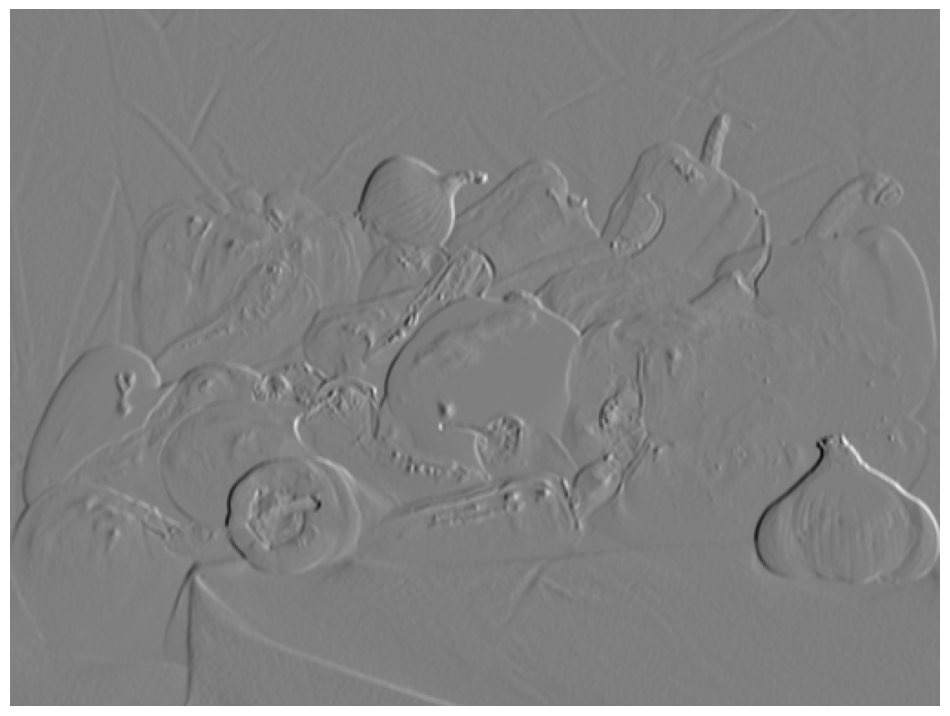

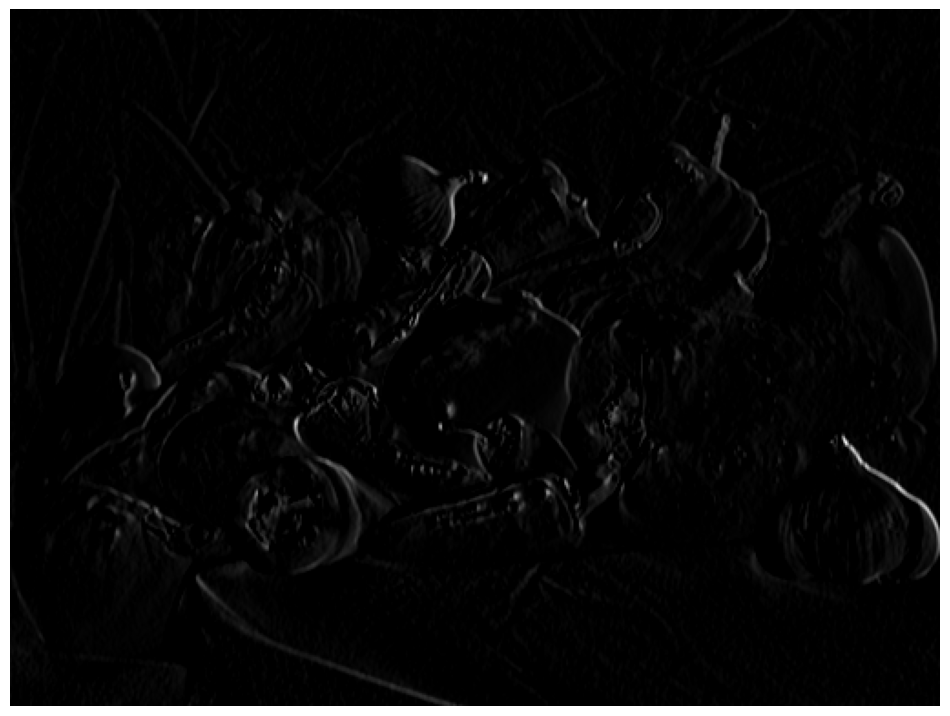

In [14]:
# --------- Vertical edges with left-to-right intensity increase ----------


# Initialize a filter
w = torch.Tensor([1,  0, -1])[None,None,:].expand(1,3,3,3)
print(f"The shape of the filter w is {list(w.shape)}")
print(f"\n The filter is {w}")

y = F.conv2d(x, w) ; # Convolution

z = F.relu(y) ;      # ReLU

plt.figure(1,figsize=(12,12))
lab.imsc(y[0])

plt.figure(2,figsize=(12,12))
lab.imsc(z[0]) ;


# --------- Vertical edges with right-to-left intensity increase ----------

# w1 = torch.Tensor([-1,  0, 1])[None,None,:].expand(1,3,3,3)

# y1 = F.conv2d(x, w1) ; # Convolution

# z1 = F.relu(y1) ;      # ReLU

# plt.figure(1,figsize=(12,12))
# lab.imsc(y1[0])

# plt.figure(2,figsize=(12,12))
# lab.imsc(z1[0]) ;

> **Tasks:**
> 
> * Run the code above and understand what the filter $\bw$ is doing.
> * Explain the final result $\bz$.

> Answers to the tasks:

  >> What the filter is doing:

      The filter computes the difference between the left and right neighboring pixels and thus it can detect vertical edges in the image by measuring horizontal intensity changes.
   
   >> Explanation of the result:
      
      Shows only the positive response because ReLU applies max(0,value), so only vertical edges with left-to-right intensity increases are preserved (bright edges) and the negative values (right-to-left edges) are clipped to zero, appearing as black.



### Part 1.3: pooling

There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:

$$
   y_{cv} = \max \{ x_{cu} : v \leq u < v+F \}.
$$

Max pooling is implemented by the `max_pool2d` function. Try this now:

the shape of the original input x is: torch.Size([1, 3, 384, 512])
the shape of the output y is: torch.Size([1, 3, 25, 34])


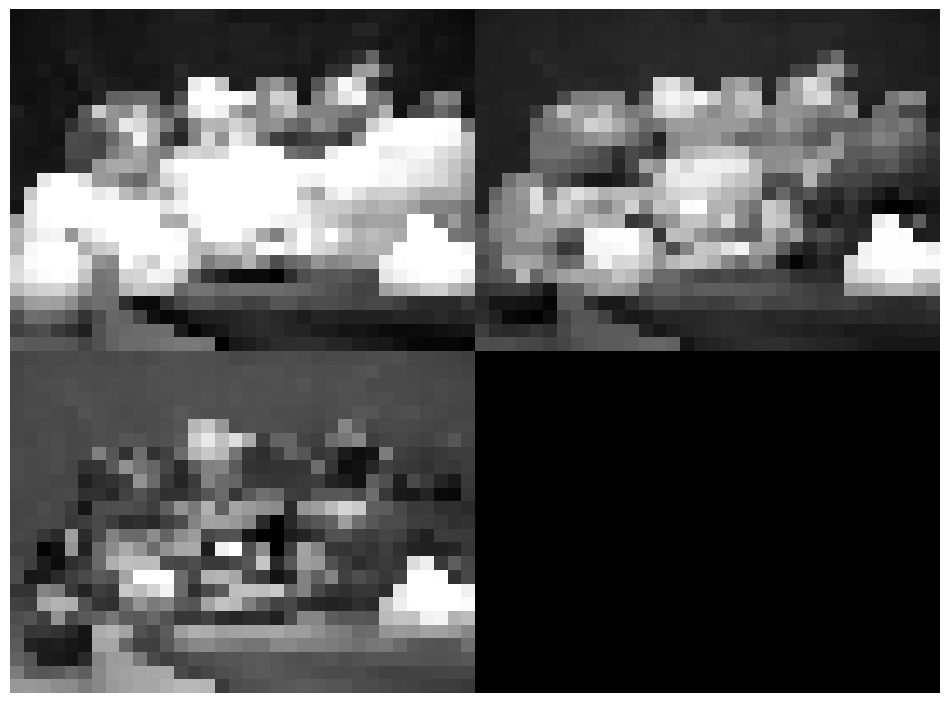

In [15]:
y = F.max_pool2d(x, 15)
  
print("the shape of the original input x is:", x.shape)
print("the shape of the output y is:", y.shape)

plt.figure(1, figsize=(12,12))
lab.imarraysc(lab.t2im(y)) ;

> **Question 5:** look at the resulting image. Can you interpret the result?


## Part 2: learning a character CNN

In this part we will learn a CNN to recognise images of characters.  

### Part 2.1: prepare the data

The code loads a structure `imdb` containing images of the characters *a, b, ..., z* rendered using 29,094 fonts downloaded from the [Google Fonts Project](https://www.google.com/fonts). The structure is a dictionary with various subfields:

In [16]:
# Load data
imdb = torch.load('data/charsdb.pth')
print(f"imdb['images'] has shape {list(imdb['images'].shape)}")
print(f"imdb['labels'] has shape {list(imdb['labels'].shape)}")
print(f"imdb['sets'] has shape {list(imdb['sets'].shape)}")

imdb['images'] has shape [29094, 1, 32, 32]
imdb['labels'] has shape [29094]
imdb['sets'] has shape [29094]


`imdb['images']` contains a $32 \times 32$ image for each character, stored as 5D tensor with $29,094 = 1,119\cdot 26$ images, each of which has dimensions $1\times 32\times 32$. `imdb['labels']` is a corresponding tensor of image labels, denoting which one of the 26 possible characters it is. `imdb['sets']` is equal to 0 for each image that should be used to train the CNN and to 1 for each image that should be used for validation.

We can visualize some of the images for the character `a` as follows:

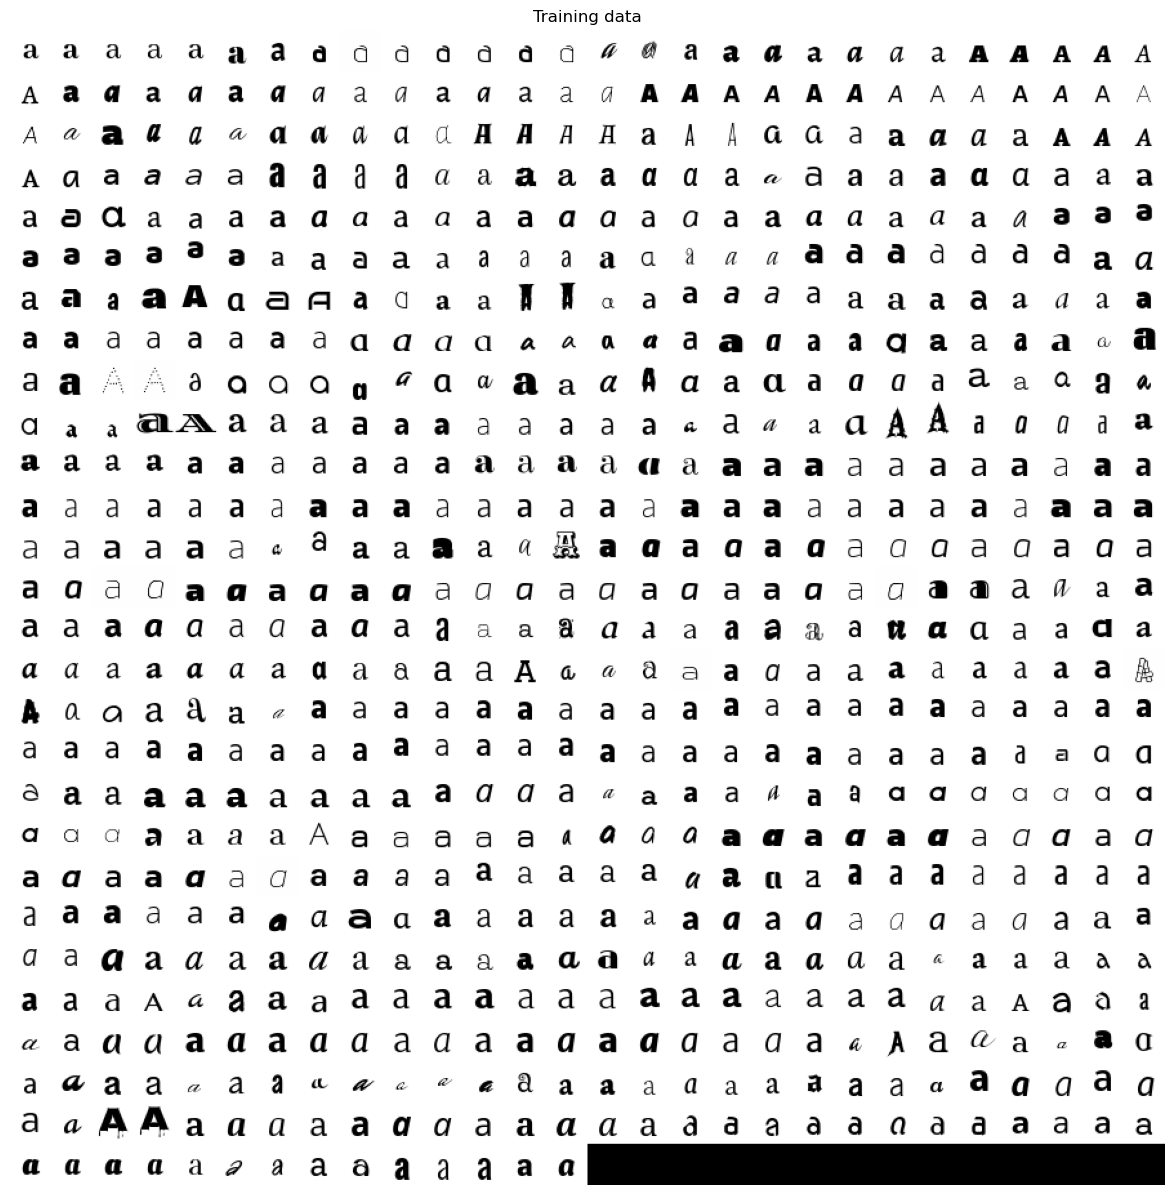

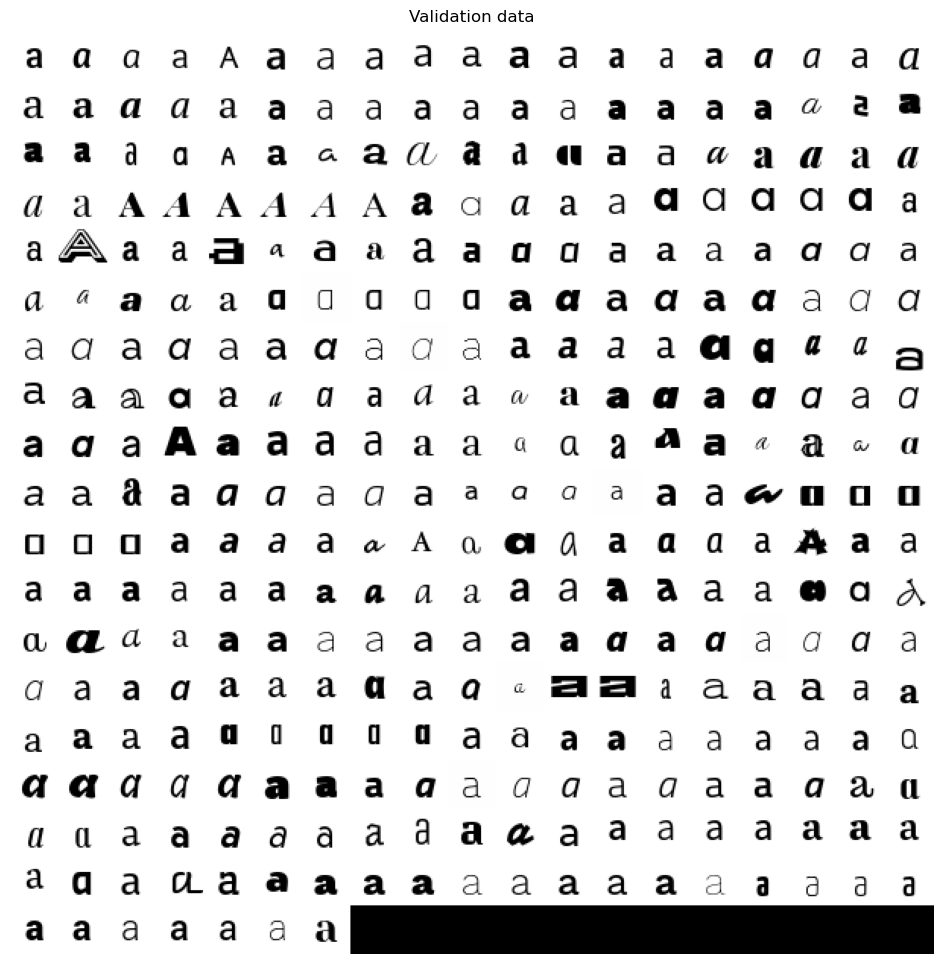

In [17]:
# Plot the training data for 'a'
plt.figure(1,figsize=(15,15))
plt.clf()
plt.title('Training data')
sel = (imdb['sets'] == 0) & (imdb['labels'] == 0)
lab.imarraysc(imdb['images'][sel,:,:,:])

# Plot the validation data for 'a'
plt.figure(2,figsize=(12,12))
plt.clf()
plt.title('Validation data')
sel = (imdb['sets'] == 1) & (imdb['labels'] == 0)
lab.imarraysc(imdb['images'][sel,:,:,:]) ;

> **Task:** look at the figure above generated by the code and at the code itself and make sure that you understand what you are looking at.

### Part 2.2: initialize a CNN architecture

So far, we have used the so-called "functional" interface to PyTorch. The framework, however, also offers modules that wrap the functional interface in convenience classes for building deep neural networks. We will now use such classes to initialize a network to recognize characters:

In [18]:
import torch.nn as nn

def new_model():
    return nn.Sequential(
        nn.Conv2d(1,20,5),        # first conv layer
        nn.MaxPool2d(2,stride=2), # downsampling
        nn.Conv2d(20,50,5),       # second conv layer
        nn.MaxPool2d(2,stride=2), # downsampling
        nn.Conv2d(50,500,4),      # third conv layer
        nn.ReLU(),                # activation
        nn.Conv2d(500,26,2),      # output layer
    )

model = new_model()

> **Task:** By inspecting the code above, get a sense of the architecture that will be trained. 

> **Question 6:** How many layers are in the above architecture? How big are the filters?

The network defines a sequence of layers. The convolutional layers implicitly contain parameter tensors (the filter weights and biases), pre-initialized using random numbers. This means that, albeit the output will be random, we can already apply the network to a character, as follows:

In [19]:
# Evaluate the network on three images
y = model(imdb['images'].narrow(0,0,3))
                        # the first dimension is the batch/sample, starting index (starts from the first image), third argument 3 is the length of the slice (selects 3 images)
print(f"The size of the network output is: {list(y.shape)}")

The size of the network output is: [3, 26, 1, 1]


Note that the *penultimate* layer has dimensions $3 \times 26 \times 1 \times 1$; this is because there are $N=3$ images in this batch, $C=26$ predicted scores, one for each possible character, and the spatial resolution is $1\times 1$, as the network makes a global decision for the whole character image. This type of network is sometimes called "fully convolutional" as it only uses convolution-like operators; an advantage is that the network can be applied to arbitrarly-wide images, which we will use later to recognise a character string. However, the last two dimensions are here a nuisance, so we get rid of them.

In [20]:
# Preserves only the first two dimensions
y = y.reshape(y.shape[:2])
print(f"The size of the network output is now {list(y.shape)}")

The size of the network output is now [3, 26]


In order to train the network, we use the cross-entropy loss, implemented by the `nn.CrossEntropyLoss()` layer.
This combines the *softmax* operator to turn character scores in probabilities:

$$
  y_{nk} = \frac{e^{x_{nk}}}{\sum_{c=0}^{C-1} e^{x_{nc}}}
$$

followed by the *log-loss* to compare such probabilities to the ground-truth characters `c`:

$$
  z = - \frac{1}{N} \sum_{n=0}^{N-1} \log y_{n c_{n}}
$$

where $0 \leq c_{n} < C$ is the ground-truth character class for the $n$-th example.

Just like any other PyTorch module, module instances are callable as if they were functions. The following code demonstrate this:

In [21]:
# Evaluate the cross-entropy loss on the network output assuming that 'a', 'b', 'c' are the ground-truth chars
loss = nn.CrossEntropyLoss()
c = torch.LongTensor([ord('a'), ord('b'), ord('c')]) - ord('a') 
z = loss(y, c)

print(f"The loss value is {z.item():.3f}")

The loss value is 3.308


### Part 2.3: train and evaluate the CNN

We are now ready to train the CNN. To this end we will use the `lab.train_model()` function provided with the practical code. This function is defined in the provided `lab` Python module, which can be [opened in the editor](../../edit/practical-cnn-pytorch-2018a/lab.py). The function is defined as follows:

```python
def train_model(model, imdb, batch_size=100, num_epochs=15, use_gpu=False, use_jitter=False)
```



By default, the training will use a mini-batch size of 100 elements, run for 15 epochs (passes through the data), not use the GPU and it will use a learning rate of 0.001.

Before the training starts, the average image value is subtracted as before. We keep around `im_mean` for later use.

In [22]:
# Remove average intensity from input images
im_mean = imdb['images'].mean()
imdb['images'].sub_(im_mean) ;

The training code is called as follows (and we will run it first for just two epochs):

beginning epoch 0 of 2
epoch: 01/02 train iter: 001/201 speed: 232.9 Hz loss: 3.26 acc: 4.0%
epoch: 01/02 train iter: 051/201 speed: 552.7 Hz loss: 3.12 acc: 15.6%
epoch: 01/02 train iter: 051/201 speed: 552.7 Hz loss: 3.12 acc: 15.6%
epoch: 01/02 train iter: 101/201 speed: 561.5 Hz loss: 2.48 acc: 30.5%
epoch: 01/02 train iter: 101/201 speed: 561.5 Hz loss: 2.48 acc: 30.5%
epoch: 01/02 train iter: 151/201 speed: 564.2 Hz loss: 1.98 acc: 44.9%
epoch: 01/02 train iter: 151/201 speed: 564.2 Hz loss: 1.98 acc: 44.9%
epoch: 01/02 train iter: 201/201 speed: 565.2 Hz loss: 1.67 acc: 53.7%
epoch: 01/02 val iter: 001/091 speed: 564.2 Hz loss: 0.17 acc: 97.0%
epoch: 01/02 val iter: 051/091 speed: 527.4 Hz loss: 0.69 acc: 82.6%
epoch: 01/02 train iter: 201/201 speed: 565.2 Hz loss: 1.67 acc: 53.7%
epoch: 01/02 val iter: 001/091 speed: 564.2 Hz loss: 0.17 acc: 97.0%
epoch: 01/02 val iter: 051/091 speed: 527.4 Hz loss: 0.69 acc: 82.6%


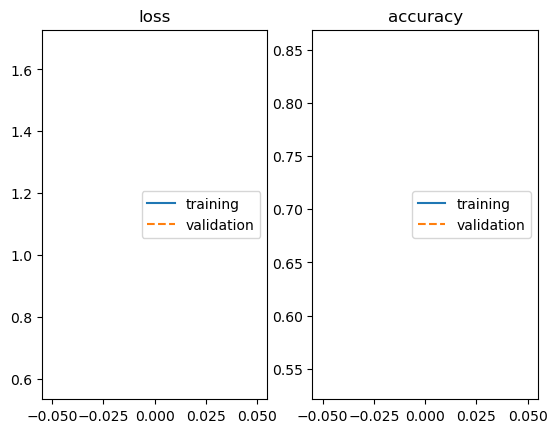

beginning epoch 1 of 2
epoch: 02/02 train iter: 001/201 speed: 577.0 Hz loss: 0.71 acc: 82.0%
epoch: 02/02 train iter: 051/201 speed: 581.2 Hz loss: 0.56 acc: 85.1%
epoch: 02/02 train iter: 051/201 speed: 581.2 Hz loss: 0.56 acc: 85.1%
epoch: 02/02 train iter: 101/201 speed: 578.6 Hz loss: 0.52 acc: 86.1%
epoch: 02/02 train iter: 101/201 speed: 578.6 Hz loss: 0.52 acc: 86.1%
epoch: 02/02 train iter: 151/201 speed: 579.0 Hz loss: 0.50 acc: 86.6%
epoch: 02/02 train iter: 151/201 speed: 579.0 Hz loss: 0.50 acc: 86.6%
epoch: 02/02 train iter: 201/201 speed: 579.0 Hz loss: 0.47 acc: 87.4%
epoch: 02/02 val iter: 001/091 speed: 578.0 Hz loss: 0.06 acc: 98.0%
epoch: 02/02 val iter: 051/091 speed: 539.7 Hz loss: 0.50 acc: 87.9%
epoch: 02/02 train iter: 201/201 speed: 579.0 Hz loss: 0.47 acc: 87.4%
epoch: 02/02 val iter: 001/091 speed: 578.0 Hz loss: 0.06 acc: 98.0%
epoch: 02/02 val iter: 051/091 speed: 539.7 Hz loss: 0.50 acc: 87.9%


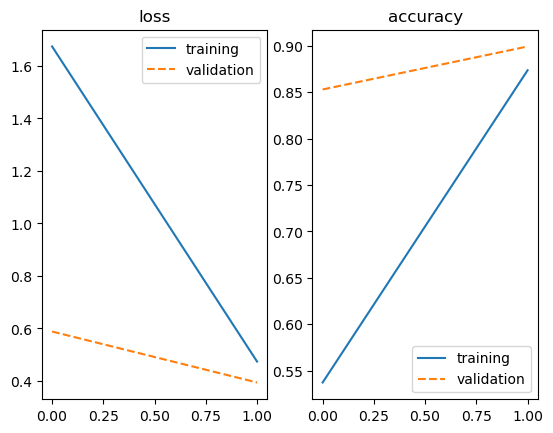

In [23]:
# Initialize the model
model = new_model()

# Run SGD to train the model
model = lab.train_model(model, imdb, num_epochs=2, use_gpu=False)

**Is the training taking too long?** If you have access to a GPU you could go to the next part to train the model for the full 15 epochs. Otherwise, you need to restart the CPU training set for 15 epochs, and wait until the training finishes.

> **Question 7:** Run the learning code and examine the plots that are produced. As training completes answer the following questions:
>
> (a)  How many images per second can you process? (Look at the rate of output on the screen)
>
> (b) **bonus** There are two sets of curves: loss and accuracy. What do you think is the difference? What is the "loss" and the "accuracy"?
>
> (c) **bonus** Some curves are labelled "training" and some other "validation".  Should they be equal? Which one should be lower than the other?

Once training is finished, the `model` object contains the trained parameters.


### Part 2.4: visualise the learned filters

The next step is to glance at the filters that have been learned:

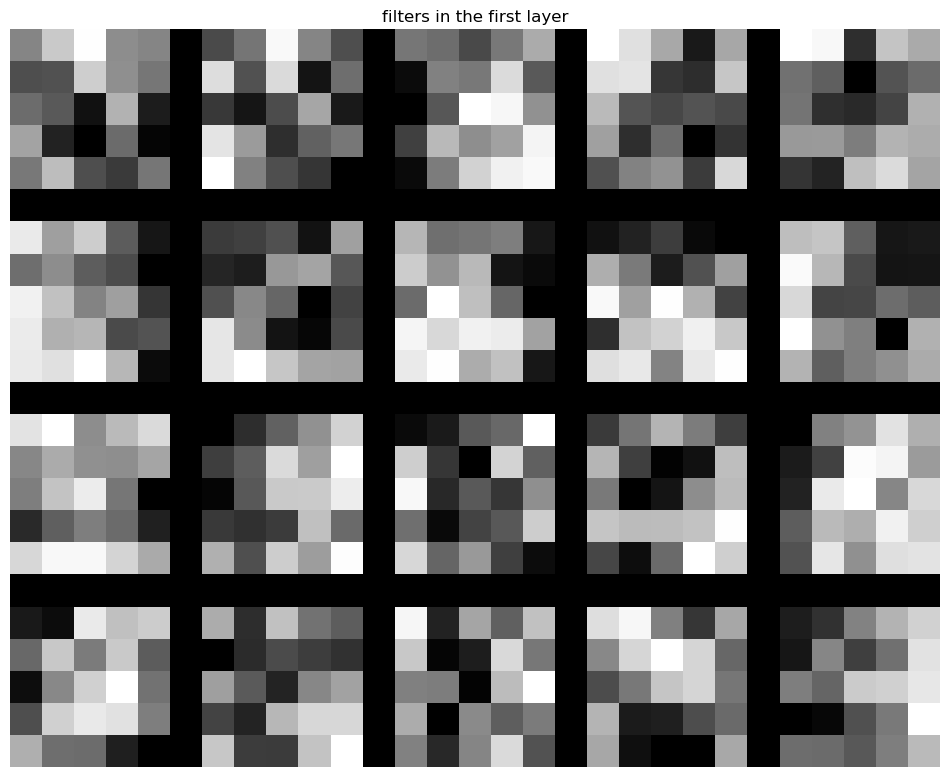

In [24]:
# Visualize the filters in the first layer
plt.figure(1, figsize=(12,12))
plt.title('filters in the first layer')
lab.imarraysc(model[0].weight, spacing=1) ;

### Part 2.5: apply the model

We now apply the model to a whole sequence of characters. This is the image `data/sentence-lato.png`:

<img width=576px src="data/sentence-lato.png" alt="sentence-lato"/>

In [25]:
# Load sentence
im = lab.imread('data/sentence-lato.png')
im.sub_(im_mean)

# Apply the CNN to the larger image
y = model(im)

# Show the string
chars = lab.decode_predicted_string(y)
print(f"Predicted string '{''.join(chars)}'")

Predicted string 'atdjrmuwemnqrnmamntpntbwrhmwemnaccqmwnlbmntdjrmuwemnmddhkomxwgjnxcdjhmuwarwmwconmdjrnlkwdmdnlhmomxddfhqamnmbxesmntbwrhmwesnqrnmnmwamwhtbp'


> **Task:** Examine the size of the CNN output using `y.shape`. Does this match your expectation?

> **Answer to the task**:

Explanation of the output shape:
* Dimension 0 (1): Batch size because we are processing 1 image
* Dimension 1 (26): Number of classes, the network outputs scores for all 26 letters (a-z)
* Dimension 2 (1): Height, the spatial height has been reduced to 1 pixel
* Dimension 3 (137): Widthm, corresponds to the horizontal positions along the input sentence image

The result does not match the expectations and I think because of the scale mismatch between training and test image. For trainning we have used images: 1 × 1 × 32 × 32 while now the test image has 1 x 1 x 32 x 576
dimensions.

Now use the `lab.plot_predicted_string()`  function to visualise the results:

In [26]:
print(f"Input sentence image shape: {im.shape}")
print(f"Output y shape: {y.shape}")

Input sentence image shape: torch.Size([1, 1, 32, 576])
Output y shape: torch.Size([1, 26, 1, 137])


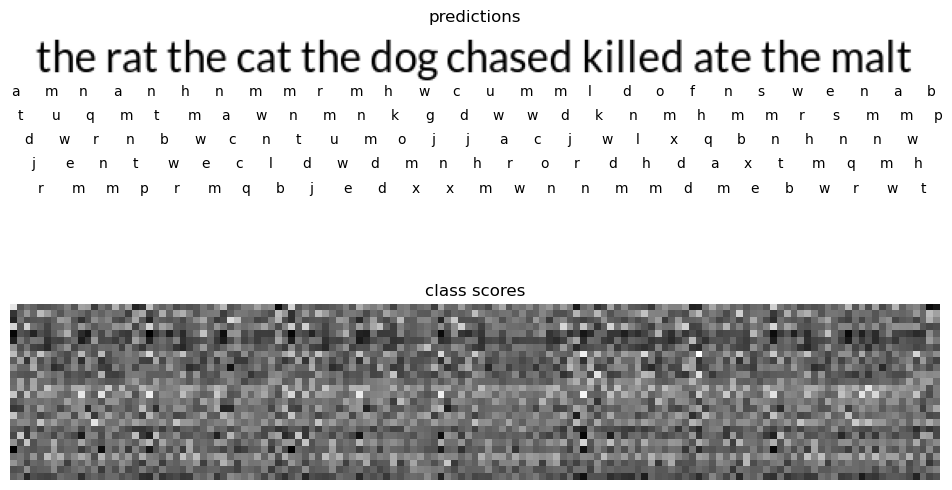

In [27]:
# Visualize the predicted string
plt.figure(1, figsize=(12,8))
lab.plot_predicted_string(im, y) ;

> **Tasks:** inspect the output of the `lab.plot_predicted_string()` function and think if:
> 
> -- Is the quality of the recognition any good?
>
> -- Does this match your expectation given the recognition rate in your validation set (as reported by `lab.train_model()` during training)?

> **Answers to the tasks:**

**1. Is the quality of the recognition any good?**

**No, the quality is very poor.** 
- Looking at the visualization output the predicted characters are mostly random gibberish (e.g., "a m n a h h n m h h m h g c r s m l n e f n w w e n a r...")

- There's no clear correspondence between the actual text "the rat the cat the dog chased killed ate the malt" and the predictions

**2. Does this match your expectation given the recognition rate in your validation set?**

**No, this poor performance it wasn't  expected because the validation accuracy was high acc: 99.0% and 87.9%** 

## Part 3: using pretrained models

A characteristic of deep learning is that it constructs *representations* of the data. These representations tend to have a universal value, or at least to be applicable to an array of problems that transcends the particular task a model was trained for. This is fortunate as training complex models requires weeks of works on one or more GPUs or hundreds of CPUs; these models can then be frozen and reused for a number of additional applications, with no or minimal additional work.

In this part we will see how PyTorch can be used to run pre-trained high-performance CNN models for image classification. These models are trained from 1.2M images in the ImageNet datasets to discriminate 1,000 different object categories.

Several [pre-trained models](https://pytorch.org/vision/stable/models.html) can be downloaded from the `torchvision` repository. A copy of one such models is provided for convenience in the practical, in the `data/alexnet.pth` file. This is the standard AlexNet model winner of the ImageNet ILSVCR 2012 Challenge.

### Part 3.1:  load a pre-trained model

The first step is to load the model itself. This is done by instantiating AlexNet using `torchvision.models.alexnet` and then loading its parameters using `torch.load`:

In [28]:
# Show the file
!ls -lh data/alexnet.pth

# Import the model
import torchvision
alexnet = torchvision.models.alexnet(weights=None)
alexnet.load_state_dict(torch.load('data/alexnet.pth'))

# # Display the model structure
# print(alexnet)

-rw-r--r-- 1 georgios.margaritis users 234M Oct 15 16:32 data/alexnet.pth


<All keys matched successfully>

> **Tasks:**
> 
> 1.   Look at the output and understand the structure of the model. How many convolutional layers are there?
> 2.   Look at the size of the file `data/alexnet.mat` on disk. This is *just the model*.

### Part 3.2: use the model to classify an image

We can now use the model to classify an image. We start from `peppers.png`:

In [29]:
from PIL import Image

# Obtain and preprocess an image
im = Image.open('data/peppers.png')

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224),),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

im_normalized = preprocess(im)[None,:]
print(f"The shape of AlexNet input is {list(im_normalized.shape)}")

The shape of AlexNet input is [1, 3, 224, 224]


The code defines a transformation which takes an input image as read by the Python PIL library (Pillow to be more exact) and normalises in a format compatible with the model `alexnet`. This amounts to: resizing the image to a fixed size of $224 \times 224$ pixels, converting the image to `single` format (in the range $[0, 1]$), and then subtracting the per-channel mean and dividing by the per-channel variance.

It is now possible to call the CNN on the normalized input `im_normalized`. This requires switching the model to evaluation mode by calling the `.eval()` method, as follows:

In [30]:
# Put the model in evaluation mode
alexnet.eval()

# Run the CNN
y = alexnet(im_normalized)

print(f"The shape of AlexNet output is {list(y.shape)}")

The shape of AlexNet output is [1, 1000]


The output tensor `y` contains the results of the computation and can be used to perform the classification:

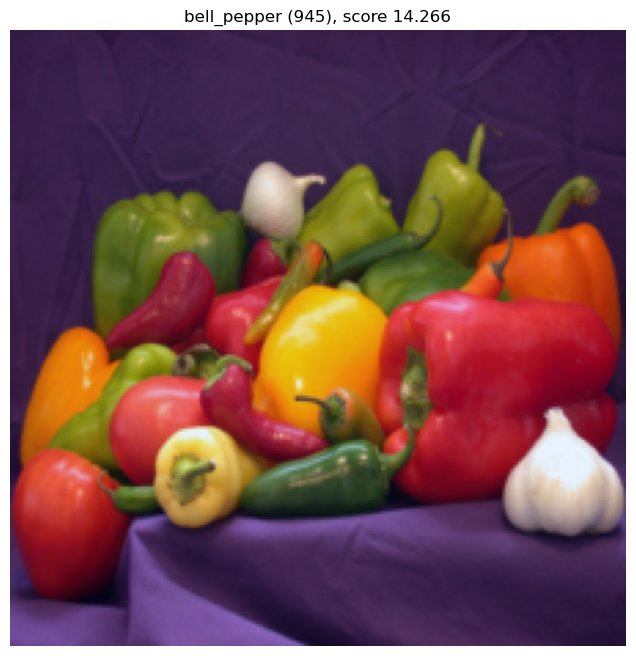

In [31]:
import json

# Get the best class index and score
best, bestk = y.max(dim=1)

# Get the corresponding class name
with open('data/imnet_classes.json') as f:
    classes = json.load(f)
name = classes[str(bestk.item())][1]

# Plot the results
plt.figure(1, figsize=(8,8))
lab.imsc(im_normalized[0])
plt.title(f"{name} ({bestk.item()}), score {best.item():.3f}") ;

### Part 3.3: use the model to classify an image you choose

> **Question 8**: Use the pre-trained model to classify an image of your choice and send a printscreen. 


The shape of AlexNet output is [1, 1000]


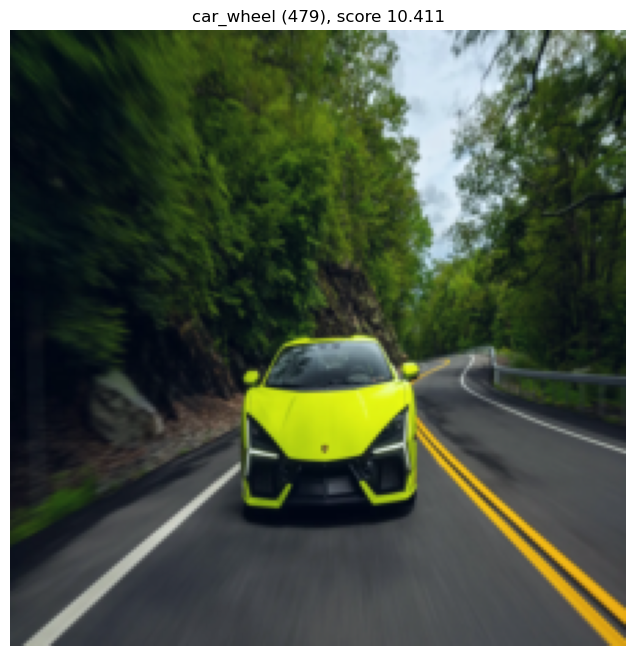

In [ ]:
lambo = Image.open('lambo.png')

lambo_normalized = preprocess(lambo)[None,:]

y_lambo = alexnet(lambo_normalized)
print(f"The shape of AlexNet output is {list(y.shape)}")

best_lambo, bestk_lambo = y_lambo.max(dim=1)
name_lambo = classes[str(bestk_lambo.item())][1]

plt.figure(1, figsize=(8,8))
lab.imsc(lambo_normalized[0])
plt.title(f"{name_lambo} ({bestk_lambo.item()}), score {best_lambo.item():.3f}") ;S


This practical is inspired by the [VGG](http://www.robots.ox.ac.uk/~vgg) computer vision practical. 
